In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/brain-tumor-mri-dataset/Training/pituitary/Tr-pi_0532.jpg
/kaggle/input/brain-tumor-mri-dataset/Training/pituitary/Tr-pi_0282.jpg
/kaggle/input/brain-tumor-mri-dataset/Training/pituitary/Tr-pi_1401.jpg
/kaggle/input/brain-tumor-mri-dataset/Training/pituitary/Tr-pi_0914.jpg
/kaggle/input/brain-tumor-mri-dataset/Training/pituitary/Tr-pi_0691.jpg
/kaggle/input/brain-tumor-mri-dataset/Training/pituitary/Tr-pi_0972.jpg
/kaggle/input/brain-tumor-mri-dataset/Training/pituitary/Tr-pi_0818.jpg
/kaggle/input/brain-tumor-mri-dataset/Training/pituitary/Tr-pi_0463.jpg
/kaggle/input/brain-tumor-mri-dataset/Training/pituitary/Tr-pi_0930.jpg
/kaggle/input/brain-tumor-mri-dataset/Training/pituitary/Tr-pi_1323.jpg
/kaggle/input/brain-tumor-mri-dataset/Training/pituitary/Tr-pi_1347.jpg
/kaggle/input/brain-tumor-mri-dataset/Training/pituitary/Tr-pi_1354.jpg
/kaggle/input/brain-tumor-mri-dataset/Training/pituitary/Tr-pi_0704.jpg
/kaggle/input/brain-tumor-mri-dataset/Training/pituitary/Tr-pi_0

In [2]:
import os
import numpy as np
import cv2
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, Dense, Input
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.metrics import classification_report
from transformers import ViTFeatureExtractor, TFViTModel
from tensorflow.keras.layers import Lambda
from tensorflow.keras.layers import Layer, Input
from transformers import TFAutoModel


In [3]:
labels = ['glioma_tumor', 'no_tumor', 'meningioma_tumor', 'pituitary_tumor']
image_size = 224
X, y = [], []

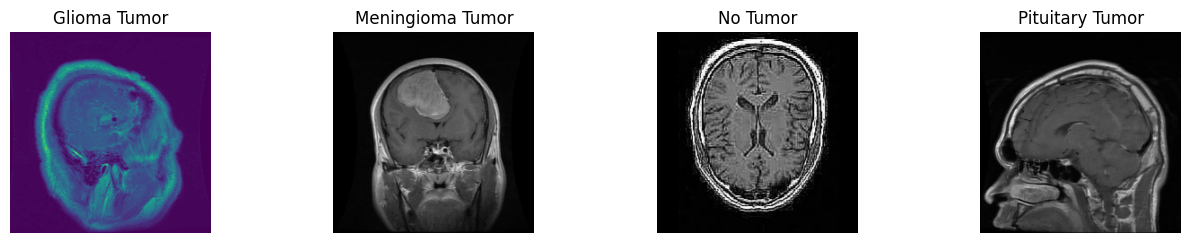

In [4]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
import os

h, w = 224, 224
plt.figure(figsize=(16, 12))

path = "../input/brain-tumor-mri-dataset/Training/"
categories = ["glioma", "meningioma", "notumor", "pituitary"]  # Updated folder names
fileLabels = ["Glioma Tumor", "Meningioma Tumor", "No Tumor", "Pituitary Tumor"]

for i, category in enumerate(categories):
    folder_path = os.path.join(path, category)
    image_files = os.listdir(folder_path)  # List all images in folder
    
    if not image_files:  # Skip empty folders
        print(f"No images found in {category} folder.")
        continue  
    
    img_path = os.path.join(folder_path, image_files[0])  # Pick the first image in the folder
    
    ax = plt.subplot(4, 4, i + 1)
    img = mpimg.imread(img_path)
    img = cv2.resize(img, (h, w))
    plt.imshow(img)
    plt.title(fileLabels[i])
    plt.axis("off")

plt.show()


In [5]:
# Define Image Size
image_size = 224

# Load Images Function
def load_images(data_dir):
    images, labels_list = [], []
    labels = sorted(os.listdir(data_dir))  # Dynamically get class labels
    for label in labels:
        folder_path = os.path.join(data_dir, label)
        for file in os.listdir(folder_path):
            img = cv2.imread(os.path.join(folder_path, file))
            img = cv2.resize(img, (image_size, image_size))
            img = img / 255.0  # Normalize pixel values (0-1)
            images.append(img)
            labels_list.append(labels.index(label))
    return np.array(images, dtype=np.float32), np.array(labels_list)

# Load Data
X_train, y_train = load_images('/kaggle/input/brain-tumor-mri-dataset/Training')
X_test, y_test = load_images('/kaggle/input/brain-tumor-mri-dataset/Testing')

# Shuffle and Split Data
X_train, y_train = shuffle(X_train, y_train, random_state=101)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=101)

# One-Hot Encoding
y_train = tf.keras.utils.to_categorical(y_train, num_classes=4)
y_val = tf.keras.utils.to_categorical(y_val, num_classes=4)
y_test = tf.keras.utils.to_categorical(y_test, num_classes=4)

# Load Vision Transformer Model
feature_extractor = ViTFeatureExtractor.from_pretrained('google/vit-base-patch16-224-in21k')
vit_model = TFAutoModel.from_pretrained("google/vit-base-patch16-224")

# Fix ViT Input Shape Issue
def preprocess_vit_input(images):
    return tf.transpose(images, perm=[0, 3, 1, 2])  # Change (batch, 224, 224, 3) -> (batch, 3, 224, 224)

# Define ViT Wrapper Layer
class ViTWrapper(Layer):
    def __init__(self, vit_model, **kwargs):
        super(ViTWrapper, self).__init__(**kwargs)
        self.vit_model = vit_model

    def call(self, inputs):
        vit_outputs = self.vit_model(inputs)
        return vit_outputs.last_hidden_state[:, 0, :]  # Extract CLS token features

    def compute_output_shape(self, input_shape):
        return (input_shape[0], self.vit_model.config.hidden_size)

    def get_config(self):
        config = super().get_config()
        config.update({
            "vit_model": self.vit_model.name_or_path
        })
        return config

    @classmethod
    def from_config(cls, config):
        vit_model = TFAutoModel.from_pretrained(config["vit_model"])
        return cls(vit_model=vit_model)

# Define Inputs
input_vit = tf.keras.Input(shape=(224, 224, 3))
input_effnet = tf.keras.Input(shape=(224, 224, 3))

# Preprocess Inputs for ViT
preprocessed_input = tf.keras.layers.Lambda(preprocess_vit_input)(input_vit)
vit_features = ViTWrapper(vit_model)(preprocessed_input)

# Load EfficientNetB0 Model
effnet = EfficientNetB0(weights='imagenet', include_top=False, input_tensor=input_effnet)
cnn_features = GlobalAveragePooling2D()(effnet.output)

# Concatenate Features
combined_features = tf.keras.layers.Concatenate()([vit_features, cnn_features])
dropout_layer = Dropout(rate=0.5)(combined_features)
out_layer = Dense(4, activation='softmax')(dropout_layer)

# Define Model with Two Inputs
model = Model(inputs=[input_vit, input_effnet], outputs=[out_layer])
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

# Callbacks
tensorboard = tf.keras.callbacks.TensorBoard(log_dir='logs')

checkpoint = tf.keras.callbacks.ModelCheckpoint(
    "hybrid_model.keras",
    monitor="val_accuracy",
    save_best_only=True,
    mode="auto",
    verbose=1
)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_accuracy',
    factor=0.3,
    patience=2,
    min_delta=0.001,
    mode='auto',
    verbose=1
)

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

# Fit the model
history = model.fit(
    [X_train, X_train], y_train,
    validation_data=([X_val, X_val], y_val),
    epochs=50,
    batch_size=32,
    callbacks=[tensorboard, checkpoint, reduce_lr, early_stopping]
)


preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


config.json:   0%|          | 0.00/69.7k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFViTModel: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing TFViTModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFViTModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFViTModel were not initialized from the PyTorch model and are newly initialized: ['vit.pooler.dense.weight', 'vit.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling (Rescaling)     │ (None, 224, 224, 3)    │              0 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ normalization             │ (None, 224, 224, 3)    │              7 │ rescaling[0][0]        │
│ (Normalization)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling_1 (Rescaling)   │ (None, 224, 224, 3)    │              0 │ normalization[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv_pad             │ (None, 225, 225, 3)    │              0 │ rescaling_1[0][0]      │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv (Conv2D)        │ (None, 112, 112, 32)   │            864 │ stem_conv_pad[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_bn                   │ (None, 112, 112, 32)   │            128 │ stem_conv[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_activation           │ (None, 112, 112, 32)   │              0 │ stem_bn[0][0]          │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_dwconv            │ (None, 112, 112, 32)   │            288 │ stem_activation[0][0]  │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_bn                │ (None, 112, 112, 32)   │            128 │ block1a_dwconv[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_activation        │ (None, 112, 112, 32)   │              0 │ block1a_bn[0][0]       │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_squeeze        │ (None, 32)             │              0 │ block1a_activation[0]… │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reshape        │ (None, 1, 1, 32)       │              0 │ block1a_se_squeeze[0]… │
│ (Reshape)                 │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reduce         │ (None, 1, 1, 8)        │            264 │ block1a_se_reshape[0]… │
│ (Conv2D)                  │                        │                │                        │
├──────────────────────

 Total params: 4,057,767 (15.48 MB)

 Trainable params: 4,015,744 (15.32 MB)

 Non-trainable params: 42,023 (164.16 KB)

Epoch 1/50
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 770ms/step - accuracy: 0.8210 - loss: 0.4968
Epoch 1: val_accuracy improved from -inf to 0.28671, saving model to hybrid_model.keras
161/161 ━━━━━━━━━━━━━━━━━━━━ 247s 964ms/step - accuracy: 0.8214 - loss: 0.4956 - val_accuracy: 0.2867 - val_loss: 1.9301 - learning_rate: 0.0010
Epoch 2/50
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 536ms/step - accuracy: 0.9587 - loss: 0.1212
Epoch 2: val_accuracy improved from 0.28671 to 0.64685, saving model to hybrid_model.keras
161/161 ━━━━━━━━━━━━━━━━━━━━ 95s 592ms/step - accuracy: 0.9587 - loss: 0.1212 - val_accuracy: 0.6469 - val_loss: 0.8008 - learning_rate: 0.0010
Epoch 3/50
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 532ms/step - accuracy: 0.9806 - loss: 0.0560
Epoch 3: val_accuracy did not improve from 0.64685
161/161 ━━━━━━━━━━━━━━━━━━━━ 94s 581ms/step - accuracy: 0.9806 - loss: 0.0561 - val_accuracy: 0.5734 - val_loss: 1.4506 - learning_rate: 0.0010
Epoch 4/50
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 532ms/step - accuracy: 0.9799 

In [6]:
pred = model.predict([X_test, X_test])  
pred = np.argmax(pred, axis=1)
y_test_new = np.argmax(y_test, axis=1)

# Evaluation
print(classification_report(y_test_new, pred))



41/41 ━━━━━━━━━━━━━━━━━━━━ 40s 782ms/step
              precision    recall  f1-score   support

           0       1.00      0.99      0.99       300
           1       0.99      1.00      0.99       306
           2       1.00      1.00      1.00       405
           3       1.00      1.00      1.00       300

    accuracy                           1.00      1311
   macro avg       1.00      1.00      1.00      1311
weighted avg       1.00      1.00      1.00      1311



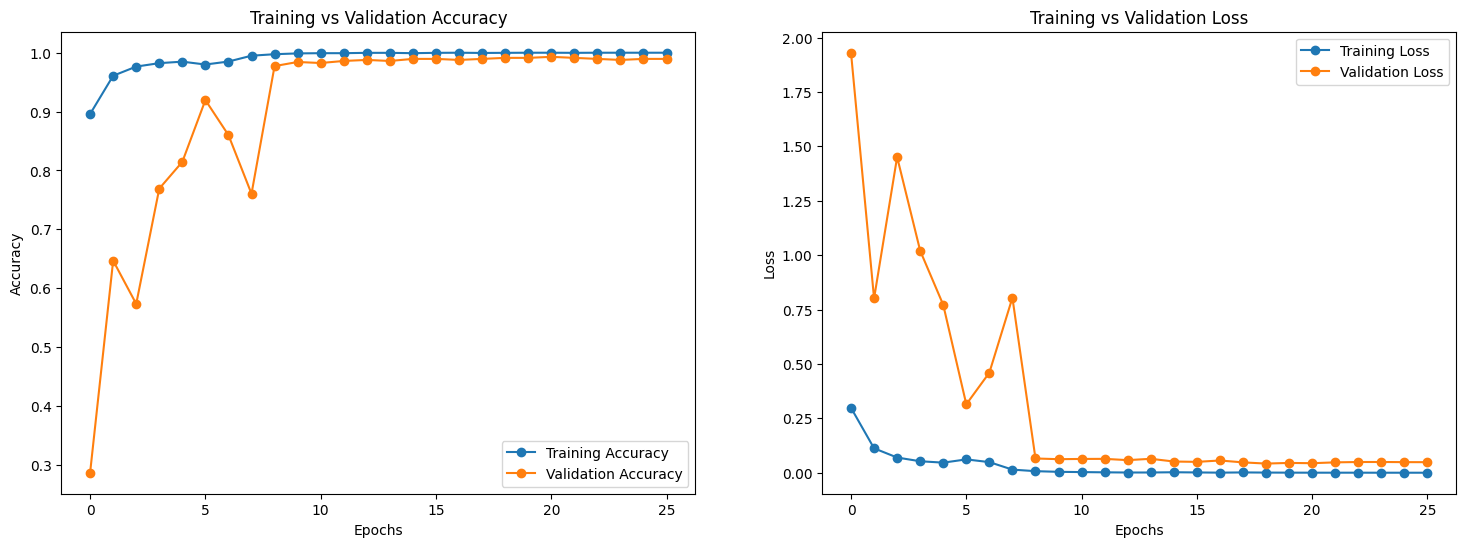

In [7]:
import matplotlib.pyplot as plt

# Extract training history
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))  # Get number of epochs dynamically

# Plot Accuracy
plt.figure(figsize=(18, 6))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy', marker='o')
plt.plot(epochs_range, val_acc, label='Validation Accuracy', marker='o')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(loc='lower right')
plt.title('Training vs Validation Accuracy')

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss', marker='o')
plt.plot(epochs_range, val_loss, label='Validation Loss', marker='o')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(loc='upper right')
plt.title('Training vs Validation Loss')

plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step


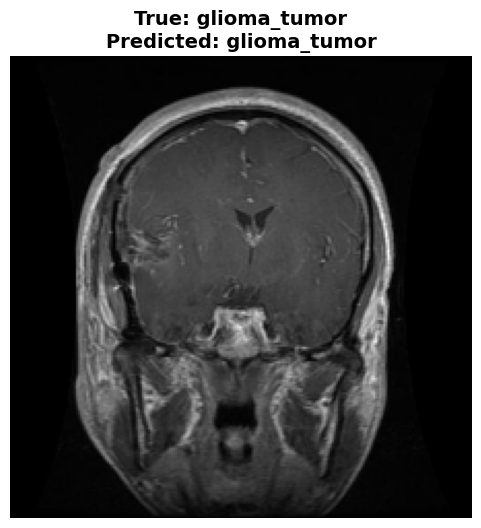

In [8]:
import random
import matplotlib.pyplot as plt

# Select a random image from the test dataset
random_index = random.randint(0, len(X_test) - 1)
random_image = X_test[random_index]
true_label = np.argmax(y_test[random_index])  # Get the actual label index

# Expand dimensions to match model input shape
input_img = np.expand_dims(random_image, axis=0)

# Predict using the trained model
prediction = model.predict([input_img, input_img])  # Pass same input to both ViT & EfficientNet
predicted_class = np.argmax(prediction, axis=1)[0]  # Get the predicted class index

# Display the image with the original and predicted labels
plt.figure(figsize=(6, 6))
plt.imshow(random_image)
plt.title(f'True: {labels[true_label]}\nPredicted: {labels[predicted_class]}', fontsize=14, fontweight='bold')
plt.axis('off')
plt.show()
